# Simulations with Model Violations: Aperiodic

In this set of simulations, we will test power spectrum parameterization performance across power spectra which violate model assumptions, specifically in the aperiodic component.

In particular, we will explore the influence of simulating data and fitting with aperiodic modes that do or do not match the properties of the data. 

In [1]:
%matplotlib inline

In [2]:
from os.path import join as pjoin

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, mode

from fooof import FOOOF, FOOOFGroup, fit_fooof_3d
from fooof.plts import plot_spectrum
from fooof.sim import gen_power_spectrum, gen_group_power_spectra
from fooof.sim.utils import set_random_seed

In [3]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from plts import *
from sims import *
from utils import *
from analysis import *
from settings import *

## Settings

In [4]:
# Set random seed
set_random_seed(303)

In [5]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [6]:
# Set a folder name (for saving data & figures)
FOLDER = '04_mv-ap/'

In [7]:
# Data & Model Setting
GEN_SIMS = True
SAVE_SIMS = True
FIT_MODELS = True
SAVE_MODELS = True

In [8]:
# Run Settings
SAVE_FIG = True
PLT_LOG = True

In [9]:
# Check the conditions to simulate across: knee values
print('Knees: ', KNEES)

Knees:  [0, 1, 10, 25, 100]


In [10]:
# Set the number of power spectra - this is per noise condition
n_psds = N_PSDS

## Example Model Violation Simulation

In this example, we will simulate a power spectrum with a knee, but fit a model in the mode without a knee, to see how much this impacts fitting. 

In [11]:
# Test generate a power spectrum
off_val = 1
kne_val = 10
exp_val = 2.0

ap = [off_val, kne_val, exp_val]
peak = [[10, 0.3, 1], [75, 0.2, 1]]
nlv = 0.0

freqs, pows = gen_power_spectrum(F_RANGE_LONG, ap, peak, nlv, F_RES)

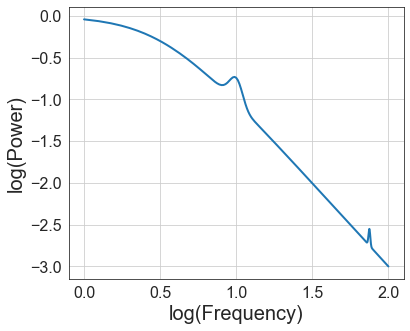

In [12]:
# Plot example simulated power spectrum
plot_spectrum(freqs, pows, True, True, ax=get_ax())

In [13]:
# Initialize FOOOF models, with different aperiodic modes
fm1 = FOOOF(aperiodic_mode='fixed')
fm2 = FOOOF(aperiodic_mode='knee')

# Fit models to example simulated spectrum
fm1.fit(freqs, pows)
fm2.fit(freqs, pows)

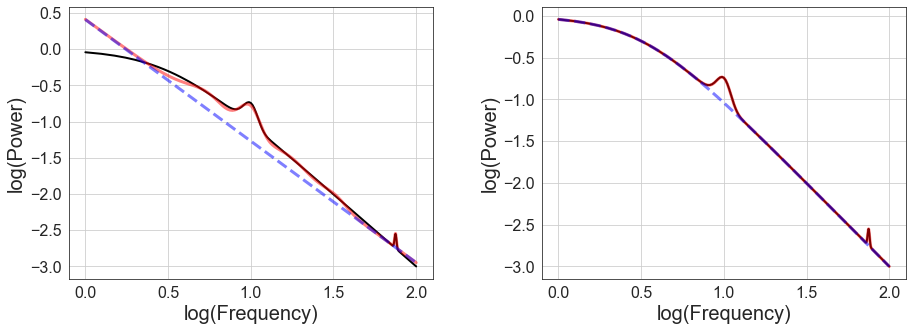

In [14]:
fig, axes = plt.subplots(1, 2, figsize=[15, 5])

fm1.plot(plt_log=True, add_legend=False, ax=axes[0])
fm2.plot(plt_log=True, add_legend=False, ax=axes[1])

plt.subplots_adjust(wspace=0.3)

In [15]:
# Check how well our example was fit, focusing on the aperiodic exponent
string = ("With a simulated exponent value of {:1.1f}:\n\n"
          "  The fixed mode fit value was:\t {:1.3f}\n"
          "  The knee mode fit value was: \t {:1.3f}")
print(string.format(exp_val,
                    fm1.get_params('aperiodic_params', 'exponent'), 
                    fm2.get_params('aperiodic_params', 'exponent')))

With a simulated exponent value of 2.0:

  The fixed mode fit value was:	 1.679
  The knee mode fit value was: 	 2.001


As we can see above, the estimation of the exponent, when there is a knee in the data, but no knee term in the model, is not a very good estimation. 

This example suggests that it is quite important for the model to be set with the appropriate mode for aperiodic fitting.

Next we can simulate an expanded set of data, to further explore model fitting in this situation. 

## Simulate Power Spectra

In this set of power spectra, we will simulate across a fixed set of knee values.

For each simulation, we will sample the other aperiodic components, and also add one peak.

We will then parameterize these data in 'fixed' mode - that is, an aperiodic mode inconsistent with the mode that simulated the data - to see how sensitive fit quality is to model assumptions.

In [16]:
# Use generators to sample peak & aperiodic parameters
peaks = gen_peaks_both()

# Get data sizes
n_conds = len(KNEES)
n_freqs = int((F_RANGE_LONG[1] - F_RANGE_LONG[0]) / F_RES + 1)

In [17]:
# Generate or load power spectra
data_name = 'mvap_kne_sims'

if GEN_SIMS:
    
    # Initialize data stores
    psds = np.empty(shape=[n_conds, n_psds, n_freqs])
    sim_params = [None] * n_conds

    # Generate simulated power spectra
    for n_ind, knee in enumerate(KNEES):
        aps = gen_ap_knee_def(knee=knee)
        freqs, psds[n_ind, :, :], sim_params[n_ind] = \
            gen_group_power_spectra(n_psds, F_RANGE_LONG, aps, peaks, NLV,
                                    F_RES, return_params=True)
        
    # Save out generated simulated data & parameter definitions
    if SAVE_SIMS:
        save_sim_data(data_name, FOLDER, freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(data_name, FOLDER)
        
# Check shape
print('n_conds, n_spectra, n_freqs : ', psds.shape)

n_conds, n_spectra, n_freqs :  (5, 1000, 397)


In [18]:
# Extract ground truth values
peak_truths, ap_truths = get_ground_truth(sim_params)

### Fit Power Spectra with FOOOF

In [19]:
# Initialize FOOOFGroup to test with
fg = FOOOFGroup(*FOOOF_SETTINGS, verbose=False)

# Print out settings used for fitting simulated power spectra
fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 8]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.1                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [20]:
# Fit power spectra
if FIT_MODELS:
    fgs = fit_fooof_3d(fg, freqs, psds)

    
    if SAVE_MODELS:
        save_model_data(data_name, FOLDER, fgs)
            
else:
    # Reload model fit data
    fgs = load_model_data(data_name, FOLDER, n_conds)

### Extract FOOOF fit Data

In [21]:
# Extract data of interest from FOOOF fits
peak_fits, ap_fits, err_fits, r2_fits, n_fit_peaks = get_fit_data(fgs)

In [22]:
# Calculate errors of the aperiodic parameters that were fit
off_errors = calc_errors(ap_truths[:, :, 0], ap_fits[:, :, 0])
exp_errors = calc_errors(ap_truths[:, :, -1], ap_fits[:, :, -1])

In [23]:
# Get count of number of fit peaks as related to simulated knee value
n_peak_counter = count_peak_conditions(n_fit_peaks, KNEES)

### Check Average Errors & Stats

In [24]:
# Check overall fit quality
temp = r2_fits.flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.8055 	0.9999
Median  R^2: 	0.9927


In [25]:
# Collect data together
datas = {
    'OFF' : off_errors,
    'EXP' : exp_errors,
    'ERR' : err_fits,
    'R^2' : r2_fits
}

In [26]:
# Print out the average error for each parameter, across number of peaks
#   Also prints out the average model error and R^2 per peak count
with np.printoptions(precision=4, suppress=True):
    for label, data in datas.items():
        print(label, '\n\t', np.nanmedian(data, 1))

OFF 
	 [0.0024 0.1083 0.7181 1.0943 1.7703]
EXP 
	 [0.0015 0.0606 0.3459 0.5072 0.8014]
ERR 
	 [0.008  0.0123 0.0267 0.028  0.026 ]
R^2 
	 [0.9995 0.9985 0.9893 0.985  0.979 ]


### Create Plots

#### Aperiodic Components

First, lets check how well we do reconstructing the aperiodic parameters that we did fit.

In the plots below we can see that the presence of a knee does impact the fit error of out aperiodic components, and that the degree of this effect scales with the value of the knee. 

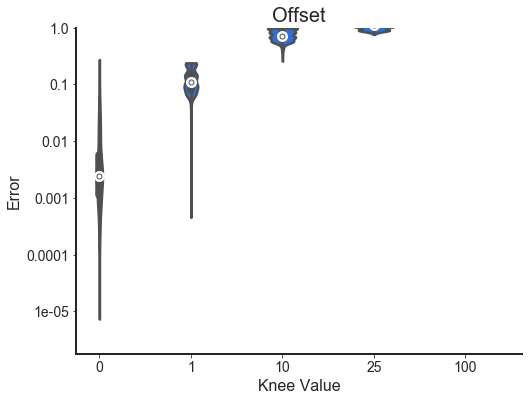

In [27]:
# Multi-peak fitting: plot error of aperiodic offset reconstruction across number of peaks
plot_errors_violin(off_errors, 'Offset', plt_log=PLT_LOG, 
                   x_axis='knees', ylim=YLIMS_AP,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'off_error'))

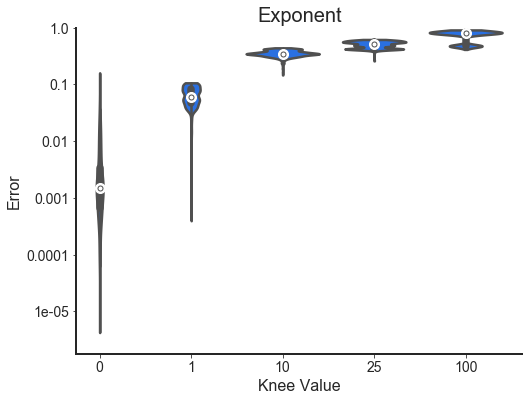

In [28]:
# Multi-peak fitting: plot error of aperiodic offset reconstruction across number of peaks
plot_errors_violin(exp_errors, 'Exponent', plt_log=PLT_LOG, 
                   x_axis='knees', ylim=YLIMS_AP,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'exp_error'))

#### Periodic Components

Here, we will check how the peak fitting went, checking in particular how many peaks are fit. 

Note that all spectra were created with a single peak. 

In the plot below, we can see that in all cases with a knee (knee value != 0), the model fits too many peaks.

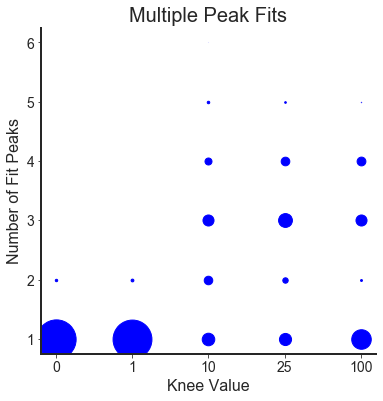

In [29]:
# Plot the correspondance between number of simulated peaks & number of fit peaks
plot_n_peaks_bubbles(n_peak_counter, x_label='knee', ms_val=12, 
                     save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'number_of_peaks'))

#### Goodness of Fit Measures

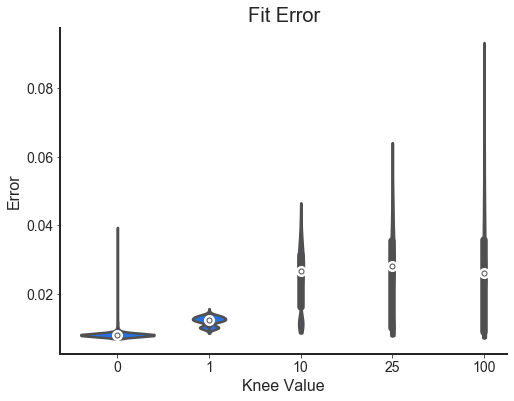

In [30]:
# Multi-peak fitting: plot error levels across knee values
plot_errors_violin(err_fits, 'Fit Error', plt_log=False, x_axis='knees',
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_error'))

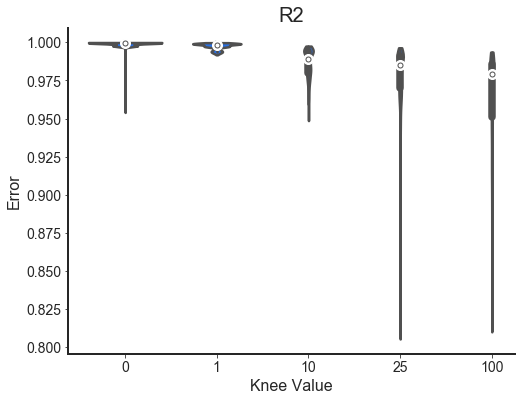

In [31]:
# Multi-peak fitting: plot R^2 levels across knee values
plot_errors_violin(r2_fits, 'R2', plt_log=False, x_axis='knees',
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_r_squared'))

### Example FOOOF Fits

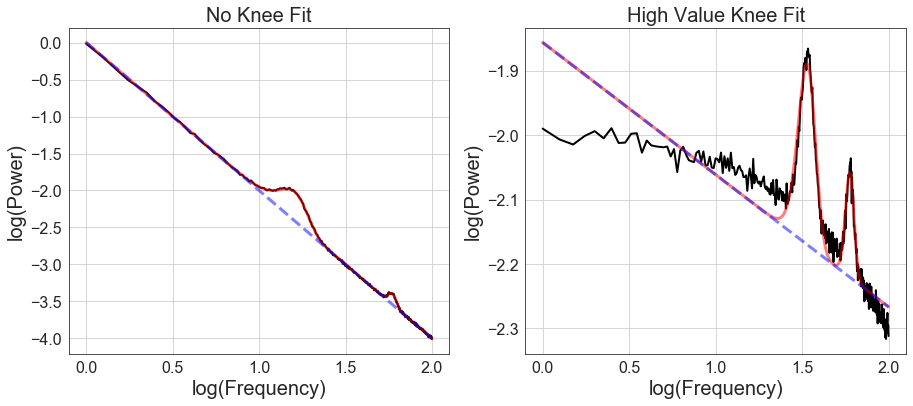

In [32]:
_, axes = plt.subplots(1, 2, figsize=[15, 6])

# Grab example case of no knee
fm_knee_0 = fgs[0].get_fooof(0, True)
axes[0].set_title('No Knee Fit', {'fontsize' : 20})
fm_knee_0.plot(plt_log=True, add_legend=False, ax=axes[0], 
               save_fig=SAVE_FIG, file_path=pjoin(FIGS_PATH, FOLDER), file_name='example_knee0')

# Grab example case of highest value knee
fm_knee_5 = fgs[-1].get_fooof(0, True)
axes[1].set_title('High Value Knee Fit', {'fontsize' : 20});
fm_knee_5.plot(plt_log=True, add_legend=False, ax=axes[1], 
               save_fig=SAVE_FIG, file_path=pjoin(FIGS_PATH, FOLDER), file_name='example_knee5')

## Fitting a knee model with no knee

Note that so far we have investigated fitting data with a knee, with a model without a knee. 

Next, let's check if there is an impact of fitting a model with a knee parameter to data without a knee.

To do so, we will run a model fits in 'knee' mode on our set of simulation with a knee value of 0. 

In [33]:
# Initialize a new FOOOFGroup, in 'knee mode'
nk_fg = FOOOFGroup(*FOOOF_SETTINGS_KNEE, verbose=False)

# Fit the first set of data, where knee value is 0
nk_fg.fit(freqs, psds[0, :, :])

In [34]:
# Get the fit data
nk_peak_fits, nk_ap_fits, nk_err_fits, nk_r2_fits, nk_n_fit_peaks = get_fit_data([nk_fg])

# Squeeze because we only have one 'condition' for these sims
nk_peak_fits = np.squeeze(nk_peak_fits)
nk_ap_fits = np.squeeze(nk_ap_fits)
nk_err_fits = np.squeeze(nk_err_fits)
nk_r2_fits = np.squeeze(nk_r2_fits)
nk_n_fit_peaks = np.squeeze(nk_n_fit_peaks)

# Extract the true simulated parameters for the no-knee data condition, used here
nk_ap_truths = ap_truths[0, :, :]

In [35]:
# Calculate errors of the aperiodic parameters that were fit
nk_off_errors = calc_errors(nk_ap_truths[:, 0], nk_ap_fits[:, 0])
nk_exp_errors = calc_errors(nk_ap_truths[:, -1], nk_ap_fits[:, -1])

In [36]:
# Check the goodness of fit measures 
print('Average fit error: \t {:1.3f}'.format(np.mean(nk_err_fits)))
print('Average fit R^2: \t {:1.3f}'.format(np.mean(nk_r2_fits)))

Average fit error: 	 0.008
Average fit R^2: 	 0.999


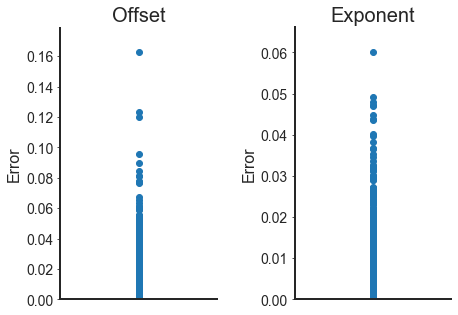

In [37]:
# Check the error of fit offset and exponent as individual values
_, axes = plt.subplots(1, 2, figsize=[7, 5])
plt.subplots_adjust(wspace=0.5)
plot_single_data(nk_off_errors, 'Offset', ax=axes[0])
plot_single_data(nk_exp_errors, 'Exponent', ax=axes[1])

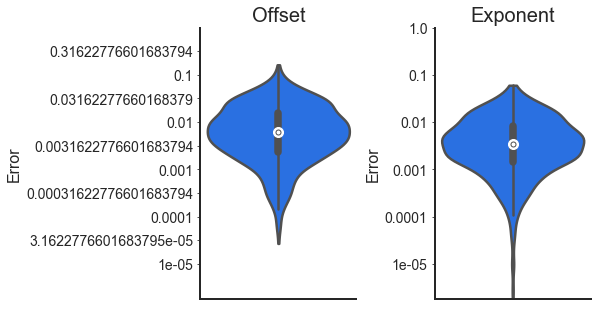

In [38]:
# Check the error of fit offset and exponent as violinplots
_, axes = plt.subplots(1, 2, figsize=[7, 5])
plt.subplots_adjust(wspace=0.5)
plot_errors_violin(nk_off_errors[np.newaxis, :], title='Offset', plt_log=PLT_LOG,
                   x_axis=None, ylim=YLIMS_AP, ax=axes[0])
plot_errors_violin(nk_exp_errors[np.newaxis, :], title='Exponent', plt_log=PLT_LOG,
                   x_axis=None, ylim=YLIMS_AP, ax=axes[1])

Mean value for knee value: 0.007


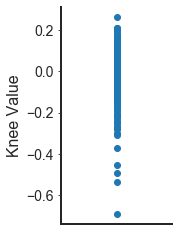

In [39]:
# Check the actual fit knee values in the knee-less data
print('Mean value for knee value: {:1.3f}'.format(
    np.mean(nk_fg.get_params('aperiodic_params', 'knee'))))
plot_single_data(nk_fg.get_params('aperiodic_params', 'knee'), ylabel='Knee Value')

In [40]:
# Check the average number of fit peaks
print('The modal number of fit peaks is:\t {:1.0f}'.format(mode(nk_n_fit_peaks).mode[0]))
print('The mean number of fit peaks is:\t {:1.2f}'.format(np.mean(nk_n_fit_peaks)))

The modal number of fit peaks is:	 1
The mean number of fit peaks is:	 1.06


#### Knee Model Fit Conclusion

For fitting a model with a knee parameter on data that does not have a knee:

- the fit knee value tends to be fit as approximately 0
    - since there is no knee, exactly 0 is the true parameter value
- the model fit overall does well: with low overall error
    - aperiodic parameters are well fit
    - there is no obvious bias in the number of fit peaks
    
This suggests fitting a model with a knee parameter to data that does not a knee is generally fine.